# Setup

In [96]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from catboost import CatBoostRegressor
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree
from geopy.distance import geodesic
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# Get To Know Data

In [122]:
train_data = pd.read_csv("binaaz_train.csv")

In [123]:
test_data = pd.read_csv("binaaz_test.csv")

In [124]:
sample_data = pd.read_csv("binaaz_sample.csv")

In [125]:
landmarks = pd.read_excel("baku_coordinates.xlsx")

In [126]:
train_data.head()

,_id,title,price,price_currency,poster,poster_type,Ünvan,description,Yeniləndi,Mərtəbə,Sahə,Otaq sayı,Kupça,İpoteka,locations,latitude,longitude,seher
0,6,"Satılır 3 otaqlı yeni tikili 135 m², Gənclik m.",300000,AZN,Mubariz,vasitəçi (agent),"Bakı şəhəri, Bakıxanov küçəsi",Təcili Satılır...Qaz Kupça var..\nRoseville...,05 Fevral 2021,5 / 17,135 m²,3,var,yoxdur,\nGənclik m.\nRespublika stadionu \nNərimanov ...,40.400420,49.851554,baki
1,22,"Satılır 3 otaqlı yeni tikili 132.5 m², Nəriman...",153000,AZN,Самир Ахмедов,vasitəçi (agent),"Bakı şəhəri, ул.Табриза 21-23",Срочно.В Наримановском р-не недалеко от 162 шк...,05 Fevral 2021,10 / 16,132.5 m²,3,yoxdur,yoxdur,\nŞərq bazarı \nNərimanov r.\n\n,40.389663,49.853717,baki
2,72,"Satılır 2 otaqlı yeni tikili 115 m², Bayıl q.",171300,AZN,Fikrət,vasitəçi (agent),"Bakı şəhəri, Q.Abbasov küçəsi","Səbail rayonu ,Bayıl qəsəbəsi Q.Abbasov küçəsi...",05 Fevral 2021,7 / 14,115 m²,2,yoxdur,yoxdur,\nSəbail r.\nBayıl q.\n\n,40.347625,49.836685,baki
3,76,"Satılır 2 otaqlı yeni tikili 43 m², Masazır q.",44500,AZN,QASIM,vasitəçi (agent),"Bakı şəhəri, İstiqlaliyyət 14","Masazır qəsəbəsi, Yeni Bakı yaşayış kompleksi ...",05 Fevral 2021,4 / 8,43 m²,2,var,yoxdur,\nAbşeron r.\nMasazır q.\n\n,40.492294,49.747231,baki
4,86,"Satılır 2 otaqlı yeni tikili 65 m², Memar Əcəm...",89900,AZN,Heydər bəy,vasitəçi (agent),"Bakı şəhəri, Mir Cəlal küç.","Tecili satilir !!\n4 cu mikrorayonda, Elmed kl...",05 Fevral 2021,12 / 18,65 m²,2,var,yoxdur,\nMemar Əcəmi m.\nNəsimi r.\n4-cü mikrorayon q...,40.417271,49.810311,baki


In [127]:
test_data.head()

,_id,title,price_currency,poster,poster_type,Ünvan,description,Yeniləndi,Mərtəbə,Sahə,Otaq sayı,Kupça,İpoteka,locations,latitude,longitude,seher
0,20886,"Satılır 1 otaqlı yeni tikili 50.4 m², Koroğlu m.",AZN,Feqan,vasitəçi (agent),"Bakı şəhəri, Qara Qarayev pr.",TECILI...SATILIR...Nizami rayonu Qara qarayev ...,20 Yanvar 2021,8 / 14,50.4 m²,1,yoxdur,yoxdur,\nKoroğlu m.\nNizami r.\n\n,40.422748,49.923277,baki
1,117465,"Satılır 3 otaqlı yeni tikili 98 m², Badamdar q.",AZN,Baloğlan,mülkiyyətçi,"Bakı şəhəri, Göyüş Qarayev küçəsi",Badamdar qəsəbəsinin mərkəzində Araz supermark...,31 May 2021,5 / 16,98 m²,3,var,var,\nSəbail r.\nBadamdar q.\n\n,40.338863,49.806822,baki
2,125220,"Satılır 5 otaqlı yeni tikili 205 m², Yasamal r.",AZN,Əli,vasitəçi (agent),"Bakı şəhəri, Zahid Xəlilov küçəsi","Mənzil Yasamal rayonu, Zahid Xəlilov küçəsində...",10 Iyun 2021,13 / 18,205 m²,5,yoxdur,yoxdur,\nYasamal r.\n\n,40.382519,49.811850,baki
3,77683,"Satılır 3 otaqlı yeni tikili 117 m², Yeni Yasa...",AZN,Saya,vasitəçi (agent),"Bakı şəhəri, Əsəd Əhmədov küçəsi","Yasamal rayonu, Yeni Yasamal qesebesi,Esed Ehm...",16 Aprel 2021,4 / 16,117 m²,3,var,yoxdur,\nYasamal r.\nYeni Yasamal q.\n\n,40.390666,49.788563,baki
4,77672,"Satılır 4 otaqlı yeni tikili 227 m², Nəsimi r.",AZN,İlqar,vasitəçi (agent),"Bakı şəhəri, Hənifə Ələsgərova küçəsi.","Nəsimi rayonu, Hənifə Ələsgərova küçəsi Adora ...",16 Aprel 2021,9 / 18,227 m²,4,yoxdur,yoxdur,\nKoala parkı \nNəsimi bazarı \nZoopark \nDost...,40.393495,49.843594,baki


In [128]:
train_data.columns

Index(['_id', 'title', 'price', 'price_currency', 'poster', 'poster_type',
       'Ünvan', 'description', 'Yeniləndi', 'Mərtəbə', 'Sahə', 'Otaq sayı',
       'Kupça', 'İpoteka', 'locations', 'latitude', 'longitude', 'seher'],
      dtype='object')

In [129]:
sample_data.head()

,_id,price
0,20886,100000
1,117465,100000
2,125220,100000
3,77683,100000
4,77672,100000


In [130]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69315 entries, 0 to 69314
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             69315 non-null  int64  
 1   title           69315 non-null  object 
 2   price           69315 non-null  int64  
 3   price_currency  69315 non-null  object 
 4   poster          69315 non-null  object 
 5   poster_type     69315 non-null  object 
 6   Ünvan           69315 non-null  object 
 7   description     69192 non-null  object 
 8   Yeniləndi       69315 non-null  object 
 9   Mərtəbə         69315 non-null  object 
 10  Sahə            69315 non-null  object 
 11  Otaq sayı       69315 non-null  int64  
 12  Kupça           69314 non-null  object 
 13  İpoteka         69315 non-null  object 
 14  locations       69315 non-null  object 
 15  latitude        69315 non-null  float64
 16  longitude       69315 non-null  float64
 17  seher           69315 non-null 

In [131]:
# Check for null values
print("\nNull Values:")
print(train_data.isnull().sum())


Null Values:
_id                 0
title               0
price               0
price_currency      0
poster              0
poster_type         0
Ünvan               0
description       123
Yeniləndi           0
Mərtəbə             0
Sahə                0
Otaq sayı           0
Kupça               1
İpoteka             0
locations           0
latitude            0
longitude           0
seher               0
dtype: int64


In [132]:
train_data['locations'].value_counts()

locations
\nYasamal r.\nYeni Yasamal q.\n\n                                                                        3954
\nŞah İsmayıl Xətai m.\nXətai r.\n\n                                                                     3784
\nXırdalan\n\n                                                                                           2527
\nYasamal r.\n\n                                                                                         1994
\nİnşaatçılar m.\nYasamal r.\n\n                                                                         1614
                                                                                                         ... 
\nPark Zorge \nKoala parkı \nNəsimi bazarı \nDostluq kinoteatrı \nRusiya səfirliyi \nNərimanov r.\n\n       1
\nNəsimi bazarı \nKoala parkı \nXətai r.\n\n                                                                1
\nKoala parkı \nDostluq kinoteatrı \nNəsimi bazarı \nPark Zorge \nSuraxanı r.\n\n                           1


In [133]:
train_data['Ünvan'].value_counts()

Ünvan
Bakı şəhəri, Gəncə prospekti                          721
Bakı şəhəri, Əsəd Əhmədov küçəsi                      712
Bakı şəhəri, Təbriz küç.                              701
Bakı şəhəri, Əsəd Əhmədov küç.                        681
Bakı şəhəri, Əsəd Əhmədov küçəsi                      642
                                                     ... 
Bakı şəhəri, Dilarə Əliyeva küç  246                    1
Bakı şəhəri, Ayaz ismayılov küçəsi ev 1 mənzil 130      1
Bakı şəhəri, Nəriman Nərimanov prospekti 37             1
Bakı şəhəri, Atatürk prospekti 56                       1
Bakı şəhəri,  Elman Ovçuyev küçəsi                      1
Name: count, Length: 20049, dtype: int64

In [134]:
# Define a function to identify problematic values in each column
def check_null_like_values(df):
    null_like_summary = {}
    for column in df.columns:
        # Check for values like 'nan', 'NaN', 'NULL', etc., case-insensitive
        null_like_values = df[column].astype(str).str.strip().str.lower().isin(['nan', 'null', 'none', '', ' ']).sum()
        null_like_summary[column] = null_like_values
    return pd.DataFrame.from_dict(null_like_summary, orient='index', columns=['Null-Like Values'])

In [135]:
# Check for null-like values
null_like_values_report = check_null_like_values(train_data)

# Display the report using Pandas' native print functionality
print("Null-Like Values in Columns:")
print(null_like_values_report)

Null-Like Values in Columns:
                Null-Like Values
_id                            0
title                          0
price                          0
price_currency                 0
poster                         0
poster_type                    0
Ünvan                          0
description                  123
Yeniləndi                      0
Mərtəbə                        0
Sahə                           0
Otaq sayı                      0
Kupça                          1
İpoteka                        0
locations                      0
latitude                       0
longitude                      0
seher                          0


In [136]:
# Check for null-like values
null_like_values_report = check_null_like_values(test_data)

# Display the report using Pandas' native print functionality
print("Null-Like Values in Columns:")
print(null_like_values_report)

Null-Like Values in Columns:
                Null-Like Values
_id                            0
title                          0
price_currency                 0
poster                         0
poster_type                    0
Ünvan                          0
description                   43
Yeniləndi                      0
Mərtəbə                        0
Sahə                           0
Otaq sayı                      0
Kupça                          0
İpoteka                        0
locations                      0
latitude                       0
longitude                      0
seher                          0


# EDA

In [416]:
train_data[train_data.duplicated()]

,_id,title,price,price_currency,poster,poster_type,Ünvan,description,Yeniləndi,Mərtəbə,Sahə,Otaq sayı,Kupça,İpoteka,locations,latitude,longitude,seher


In [417]:
# Check basic statistics
print("Basic Statistics:")
print(train_data.describe())

Basic Statistics:
                 _id         price     Otaq sayı      latitude     longitude
count   69315.000000  6.931500e+04  69315.000000  69315.000000  69315.000000
mean    69354.073462  1.928901e+05      2.779124     40.398972     49.842873
std     46130.321678  1.880708e+05      0.966102      0.190983      0.743952
min         1.000000  1.000000e+01      1.000000     39.247907   -144.714092
25%     29066.500000  1.050000e+05      2.000000     40.382464     49.808933
50%     61309.000000  1.500000e+05      3.000000     40.393477     49.837887
75%    118875.500000  2.290000e+05      3.000000     40.405799     49.871810
max    147190.000000  1.275000e+07     20.000000     89.464469     50.331135


There are outliers in latitude and longitude for sure.

In [418]:
# Check unique values in categorical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nUnique values in {col}: {train_data[col].nunique()}")


Unique values in title: 14475

Unique values in price_currency: 1

Unique values in poster: 3907

Unique values in poster_type: 2

Unique values in Ünvan: 20049

Unique values in description: 60424

Unique values in Yeniləndi: 178

Unique values in Mərtəbə: 461

Unique values in Sahə: 1827

Unique values in Kupça: 2

Unique values in İpoteka: 2

Unique values in locations: 2527

Unique values in seher: 3


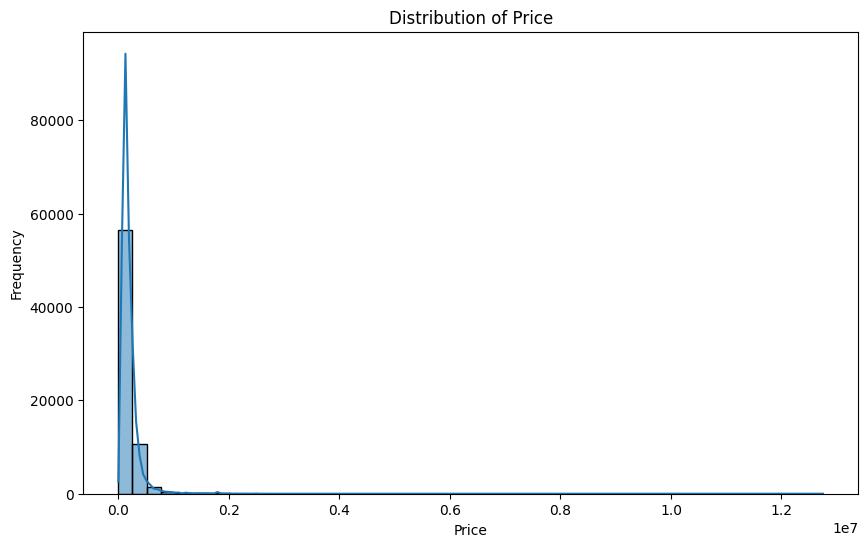

In [419]:
# Distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(train_data['price'], bins=50, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

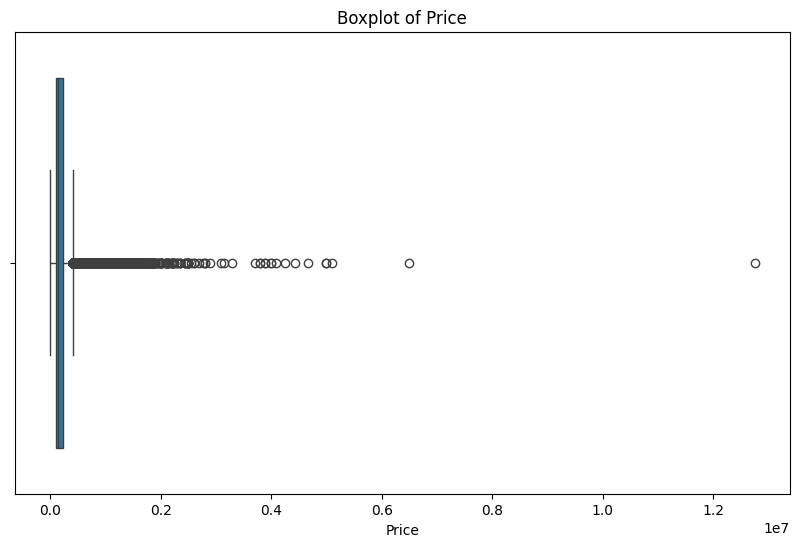

In [420]:
# Boxplot of price
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['price'])
plt.title("Boxplot of Price")
plt.xlabel("Price")
plt.show()

A lot of outliers in price.

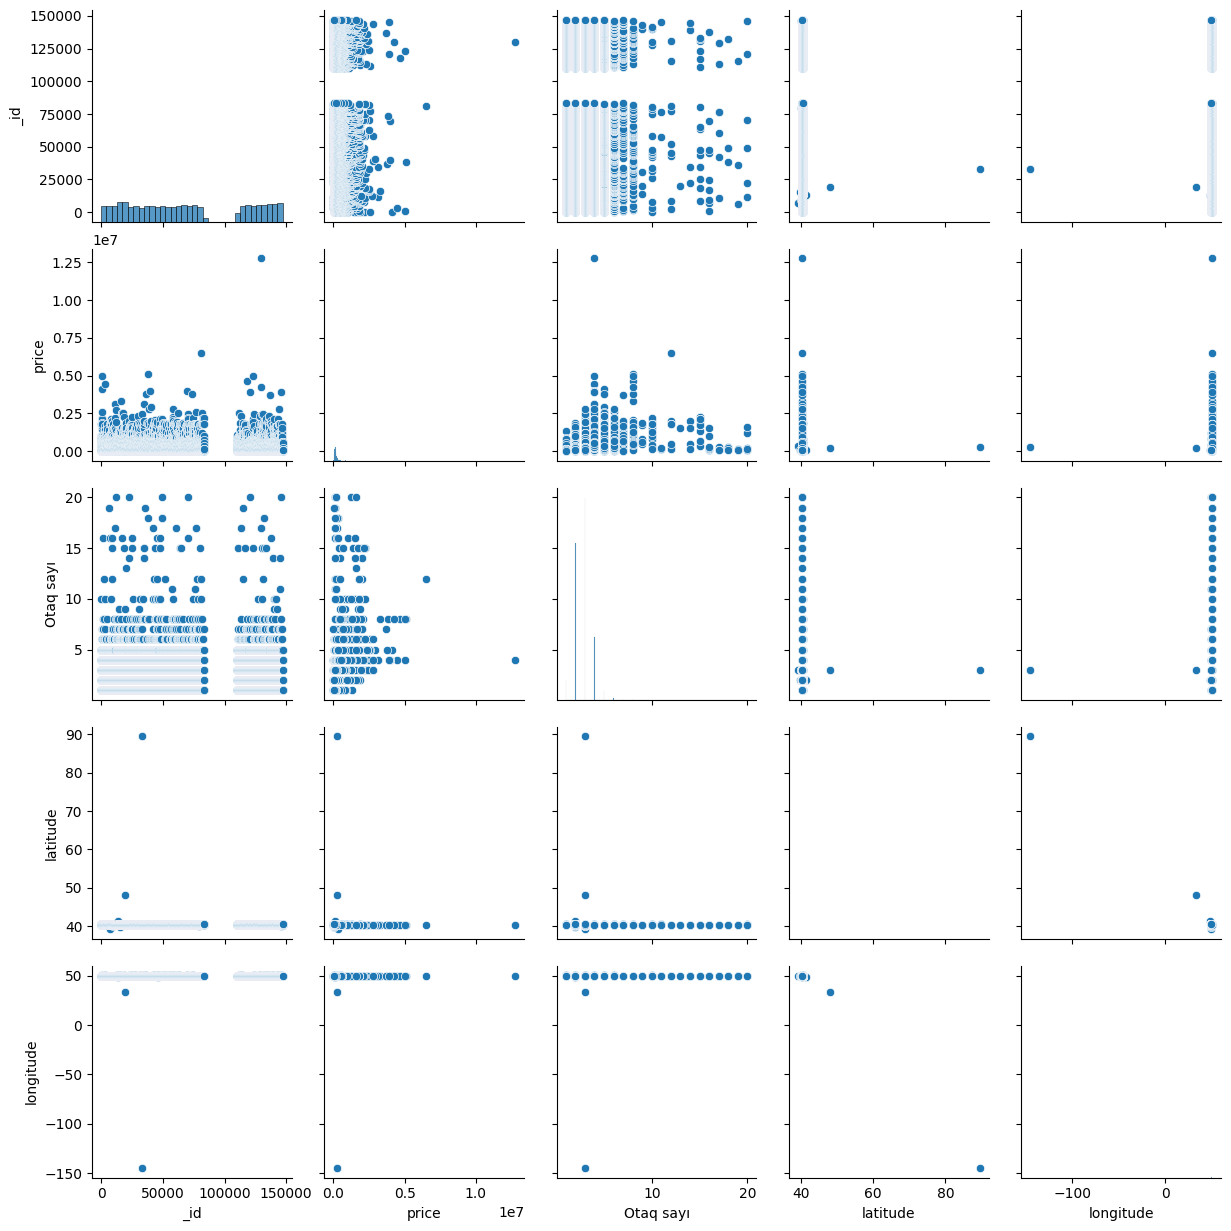

In [19]:
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

# Pairplot for numerical features
sns.pairplot(train_data[numerical_columns])
plt.show()

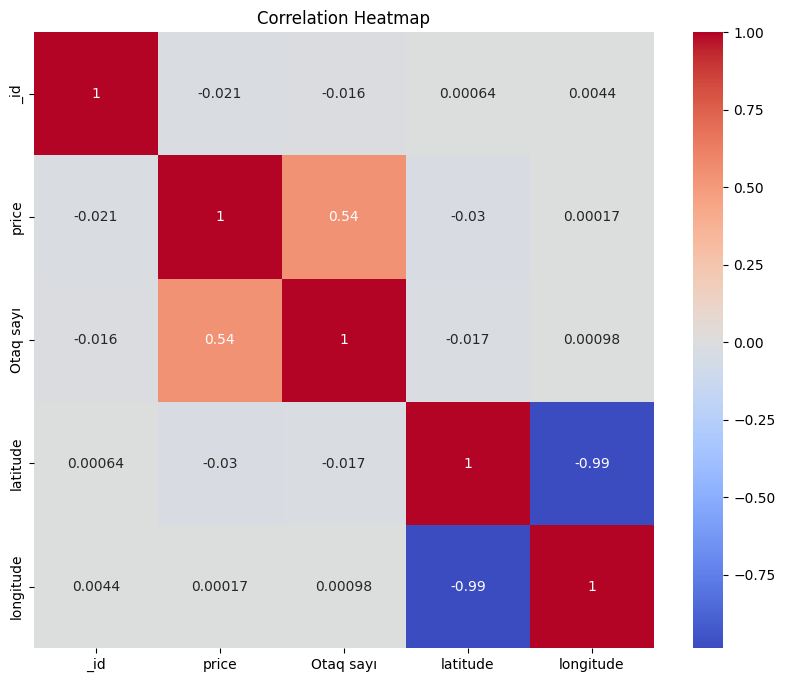

In [20]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numerical_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

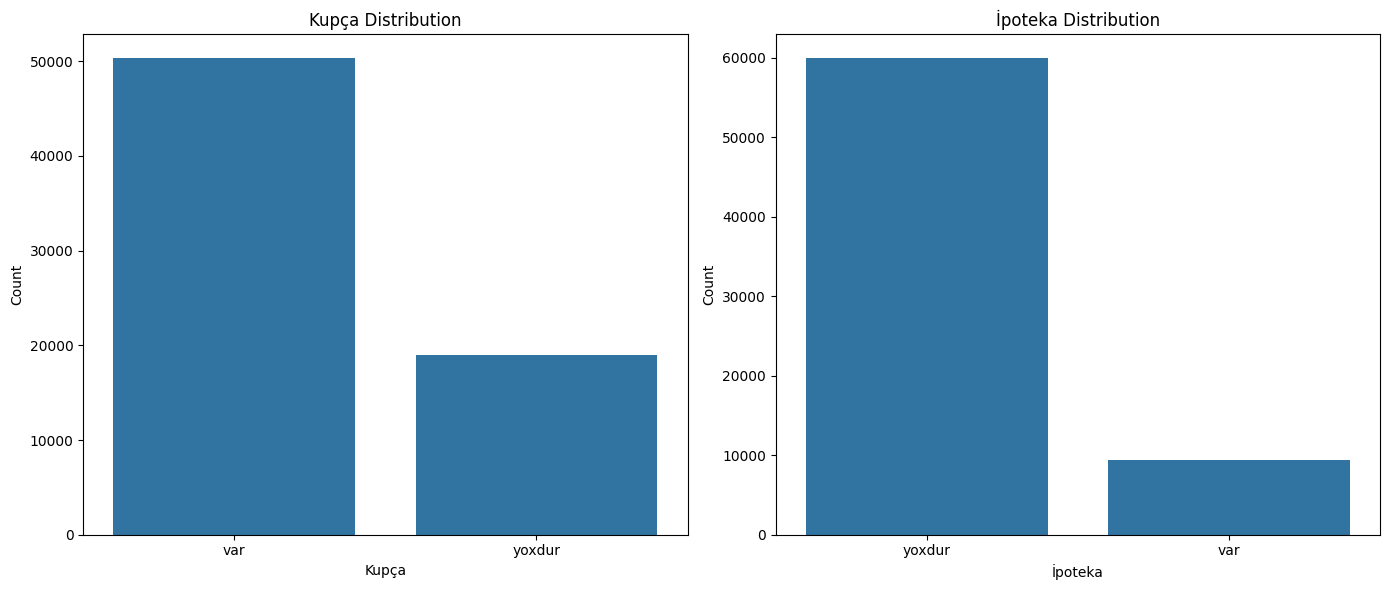

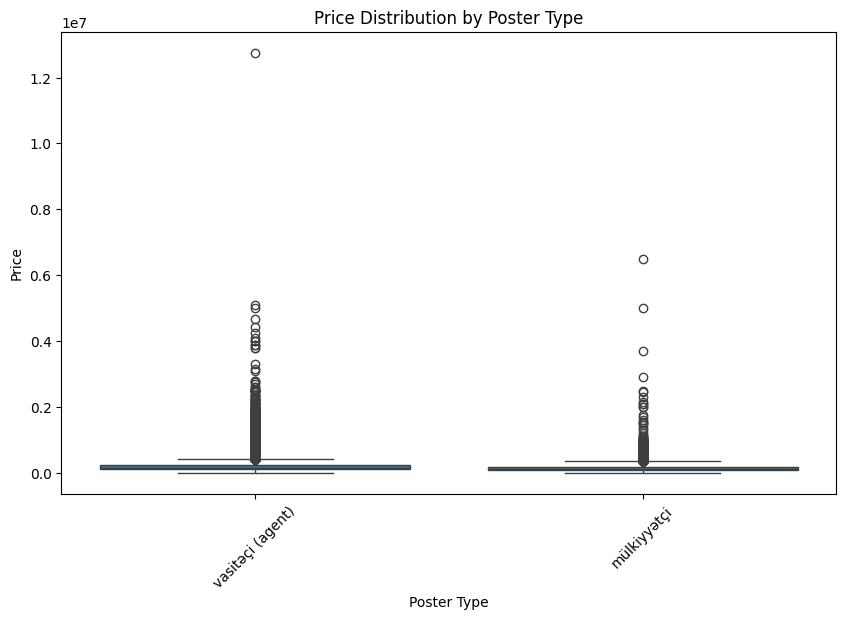

In [21]:
# Bar plots for Kupça and İpoteka
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Kupça', data=train_data)
plt.title("Kupça Distribution")
plt.xlabel("Kupça")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x='İpoteka', data=train_data)
plt.title("İpoteka Distribution")
plt.xlabel("İpoteka")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Price distribution by poster_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='poster_type', y='price', data=train_data)
plt.title("Price Distribution by Poster Type")
plt.xlabel("Poster Type")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

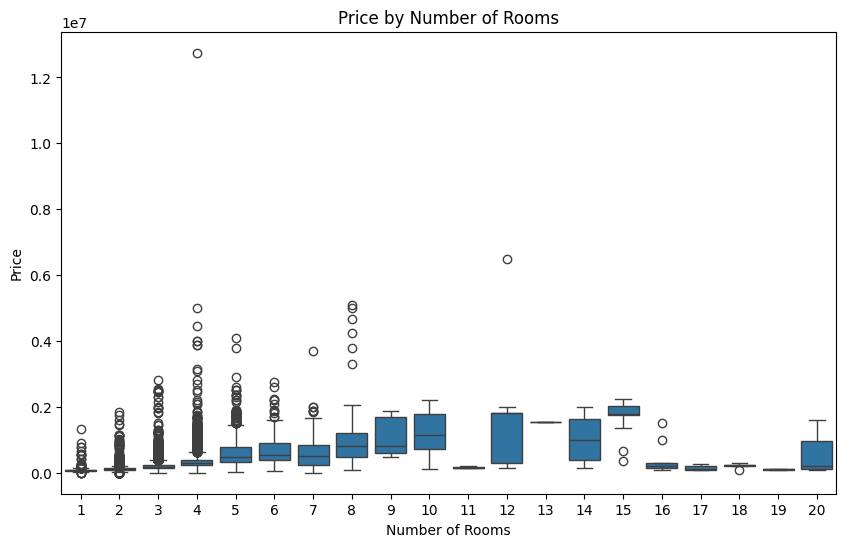

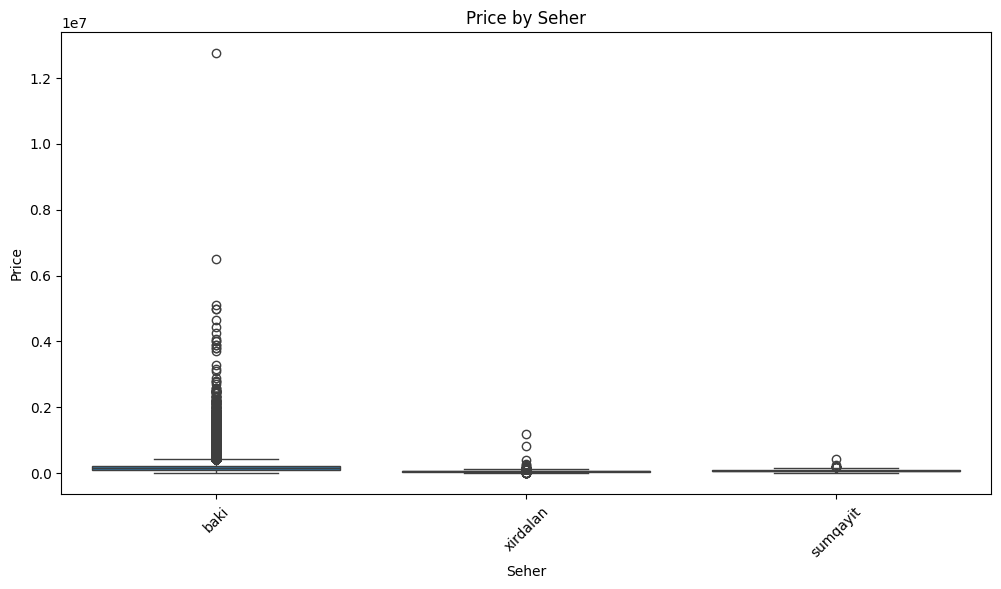

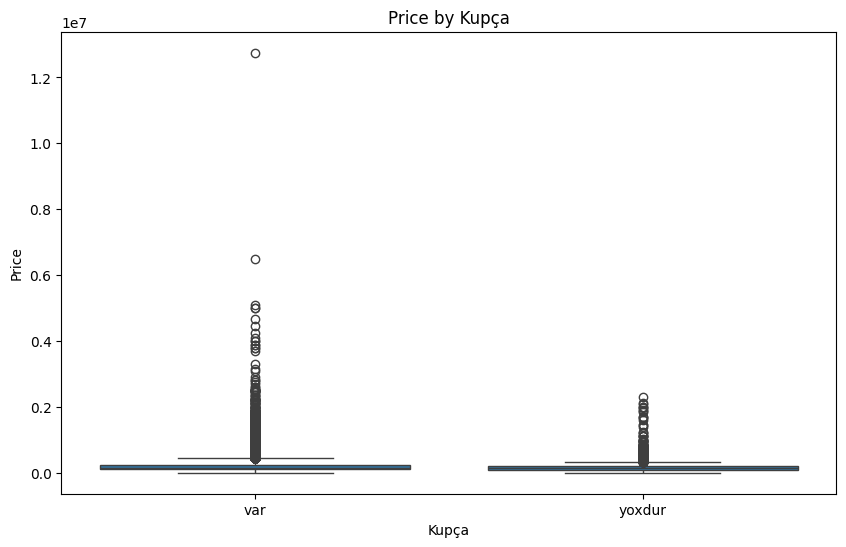

In [22]:
# Price by number of rooms
plt.figure(figsize=(10, 6))
sns.boxplot(x='Otaq sayı', y='price', data=train_data)
plt.title("Price by Number of Rooms")
plt.xlabel("Number of Rooms")
plt.ylabel("Price")
plt.show()

# Price by seher
plt.figure(figsize=(12, 6))
sns.boxplot(x='seher', y='price', data=train_data)
plt.title("Price by Seher")
plt.xlabel("Seher")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

# Price by Kupça
plt.figure(figsize=(10, 6))
sns.boxplot(x='Kupça', y='price', data=train_data)
plt.title("Price by Kupça")
plt.xlabel("Kupça")
plt.ylabel("Price")
plt.show()

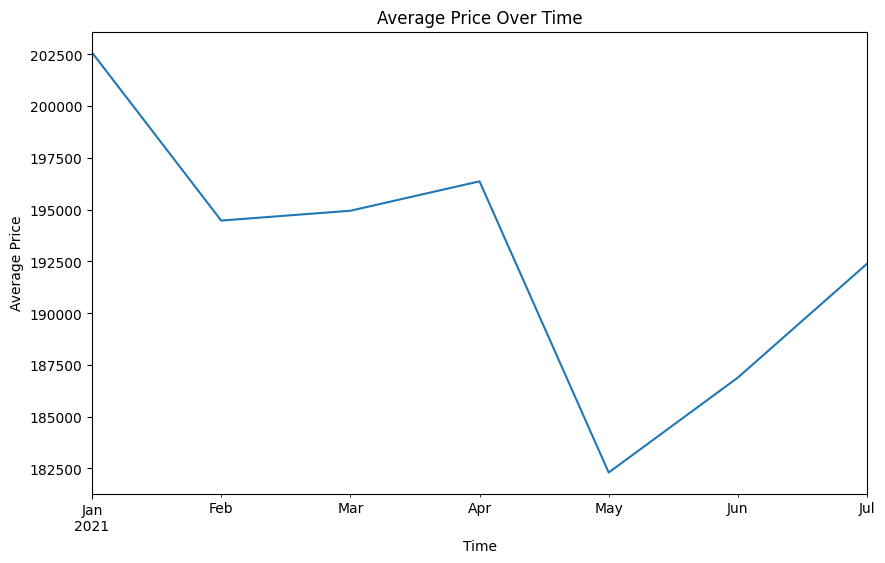

In [23]:
# Convert Yeniləndi to datetime
month_map = {
     "Yanvar": "January",
        "Fevral": "February",
        "Mart": "March",
        "Aprel": "April",
        "May": "May",
        "İyun": "June",
        "İyul": "July",
        "Avqust": "August",
        "Sentyabr": "September",
        "Oktyabr": "October",
        "Noyabr": "November",
        "Dekabr": "December",
        "мая": "May",
        "Iyun": "June",
        "Iyul": "July"
}

train_data['Yeniləndi'] = train_data['Yeniləndi'].replace(month_map, regex=True)
train_data['Yeniləndi'] = pd.to_datetime(train_data['Yeniləndi'], format='%d %B %Y')

# Plot price over time
plt.figure(figsize=(10, 6))
train_data.groupby(train_data['Yeniləndi'].dt.to_period('M'))['price'].mean().plot()
plt.title("Average Price Over Time")
plt.xlabel("Time")
plt.ylabel("Average Price")
plt.show()

Winter times are the most expensive period.

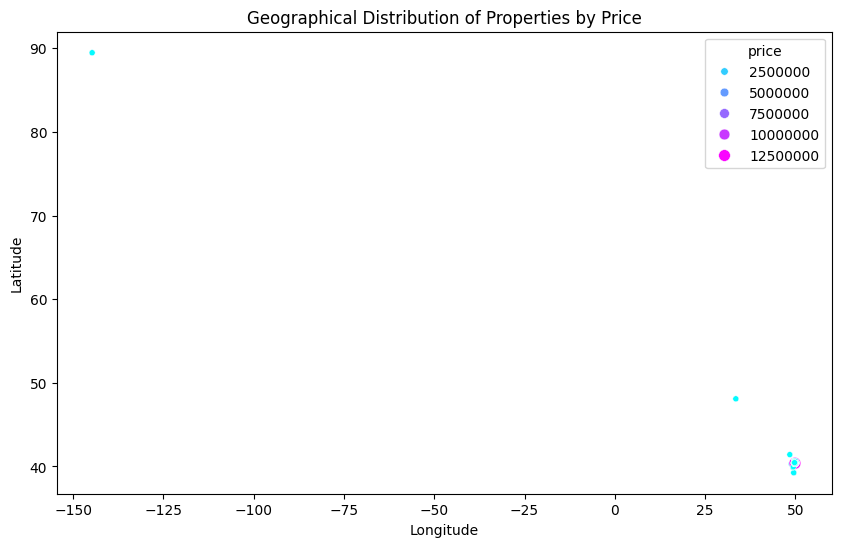

In [25]:
# Scatter plot of latitude and longitude
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='price', data=train_data, palette='cool', size='price')
plt.title("Geographical Distribution of Properties by Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Preprocess Data

## Decide Whether To Keep Columns or Not

In [137]:
def preprocess_data(data):
    data = data.drop(columns=['price_currency'])
    data = data.drop(columns=['poster'])
    data = data.drop(columns=['locations'])
    data = data.drop(columns=['title'])
    data = data.drop(columns=['Ünvan'])
    
    return data

In [138]:
# keep locations for later
df_train_locations = train_data['locations']
df_test_locations = test_data['locations']

In [139]:
df_train = preprocess_data(train_data)

In [140]:
df_test = preprocess_data(test_data)

## Feature Engineering

In [141]:
# Helper function to search for keywords
def search_keywords(text, keywords):
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0

In [142]:
# Check for null-like values in the 'description' column
def is_null_like(text):
    return str(text).strip().lower() in ['nan', 'null', 'none', '', ' ']

In [143]:
# Add a helper function to safely extract features
def safe_extract(func, text, default_value):
    if is_null_like(text):
        return default_value
    return func(text)

In [144]:
def preprocess_date_column(data):
    # Mapping Azerbaijani month names to numbers
    month_map = {
        "Yanvar": "January",
        "Fevral": "February",
        "Mart": "March",
        "Aprel": "April",
        "May": "May",
        "İyun": "June",
        "İyul": "July",
        "Avqust": "August",
        "Sentyabr": "September",
        "Oktyabr": "October",
        "Noyabr": "November",
        "Dekabr": "December",
        "мая": "May",
        "Iyun": "June",
        "Iyul": "July"
    }

    # Convert "Yeniləndi" to datetime
    data['Yeniləndi'] = data['Yeniləndi'].replace(month_map, regex=True)
    data['Yeniləndi'] = pd.to_datetime(data['Yeniləndi'], format='%d %B %Y')

    # Extract useful features
    # data['updated_year'] = data['Yeniləndi'].dt.year
    data['updated_month'] = data['Yeniləndi'].dt.month
    # data['updated_day'] = data['Yeniləndi'].dt.day
    # data['updated_dayofweek'] = data['Yeniləndi'].dt.dayofweek  # Monday=0, Sunday=6

    # Optionally drop the original date column if not needed
    data = data.drop(columns=['Yeniləndi'])

    return data

In [145]:
def preprocess_further(df):
    df = df.drop_duplicates()
    
    # description column
    
    # 1. Urgency
    df['is_urgent'] = df['description'].apply(
       lambda x: safe_extract(lambda t: search_keywords(t, ['təcili', 'tecili', 'son endirim', 'qiymətdə razılaşma']), x, 0)
    )
    
    # 2. Quality Indicators
    quality_keywords = {
       'is_premium': ['premium klass', 'avropa'],
       'is_newly_built': ['tam təmirli', 'təmir edildikdən sonra', 'temirli'],
        'has_included_items': ['mətbəx mebeli', 'mebel', 'qonaq otağı dəsti', 'kondisioner', 'paltaryuyan'],
    }
    
    for feature, keywords in quality_keywords.items():
        df[feature] = df['description'].apply(
           lambda x: safe_extract(lambda t: search_keywords(t, keywords), x, 0))
    
    # 3. Location Proximity
    df['near_metro'] = df['description'].apply(
       lambda x: safe_extract(lambda t: search_keywords(t, ['meto', 'metro']), x, 0)
    )
    
    # Impute missing values for binary features
    binary_features = ['is_urgent', 'is_premium', 'is_newly_built', 'has_included_items', 'near_metro']
    for feature in binary_features:
        df[feature] = df[feature].fillna(0)  # Impute missing values with 0 (default assumption)
    
    df = df.drop(columns=["description"])
    
    df = preprocess_date_column(df)
    
    # Clean "Sahə" column by removing "m²" and converting to numeric
    if 'Sahə' in df.columns:
        df['Sahə'] = df['Sahə'].str.split(" ").str[0].astype(float)
        
    # Parsing the "Mərtəbə" column (e.g., floor information)
    if 'Mərtəbə' in df.columns:
        # Splitting into current_floor and total_floors
        df[['current_floor', 'total_floors']] = df['Mərtəbə'].str.split(' / ', expand=True)
        df['current_floor'] = pd.to_numeric(df['current_floor'], errors='coerce')
        df['total_floors'] = pd.to_numeric(df['total_floors'], errors='coerce')
        
        # Drop the original "Mərtəbə" column
        df = df.drop(columns=['Mərtəbə'])   
    
    # Fill missing values in 'Kupça' with 'yox'
    df['Kupça'] = df['Kupça'].fillna('yoxdur')
    
    # Define the mapping of order
    kupca_order = ['yoxdur', 'var']  
    ipoteka_order = ['yoxdur', 'var'] 
    
    encoder = OrdinalEncoder(categories=[kupca_order, ipoteka_order])
    
    df[['Kupça_encoded', 'İpoteka_encoded']] = encoder.fit_transform(df[['Kupça', 'İpoteka']])
    
    df.drop(columns=['Kupça', 'İpoteka'], inplace=True)
    
    for col in ['seher', 'poster_type']:
        if col in df.columns:
            le = LabelEncoder()
            df[col + '_encoded'] = le.fit_transform(df[col].astype(str))

    # Drop original 'seher' and 'poster_type' columns
    df = df.drop(columns=['seher', 'poster_type'], errors='ignore')
    
    return df

In [146]:
df_train = preprocess_further(df_train)

In [147]:
df_test = preprocess_further(df_test)

# Handle Outliers

In [148]:
# Define numerical columns for outlier detection
numerical_columns = [
    'price', 'Sahə', 'Otaq sayı', 'latitude', 'longitude', 
    'current_floor', 'total_floors', 'Kupça_encoded', 'İpoteka_encoded'
]

numerical_columns_test = [
    'Sahə', 'Otaq sayı', 'latitude', 'longitude', 
    'current_floor', 'total_floors', 'Kupça_encoded', 'İpoteka_encoded'
]

In [149]:
# Function to remove outliers based on Z-score
def remove_outliers_zscore(df, numerical_columns, threshold=3):
    """
    Removes rows from the DataFrame where any of the numerical columns have Z-scores
    greater than the specified threshold.

    Args:
    - df: Input DataFrame.
    - numerical_columns: List of numerical columns to check for outliers.
    - threshold: Z-score threshold to identify outliers.

    Returns:
    - DataFrame without outliers.
    """
    z_scores = np.abs((df[numerical_columns] - df[numerical_columns].mean()) / df[numerical_columns].std())
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    return filtered_df

In [150]:
# Remove outliers
df_train = remove_outliers_zscore(df_train, numerical_columns)

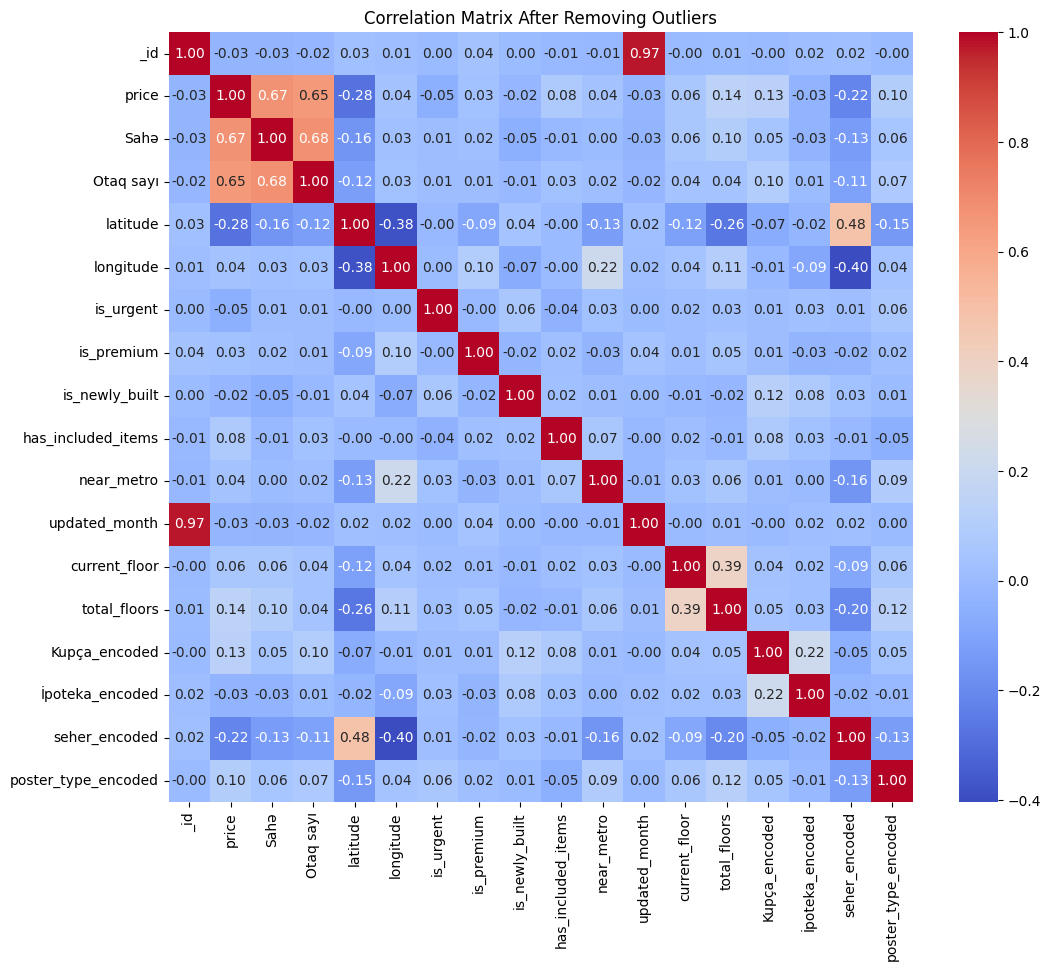

In [151]:
# Recompute correlation matrix
correlation_matrix_no_outliers = df_train.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_no_outliers, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix After Removing Outliers")
plt.show()

# Latitude and Longitude

## Rayon

In [152]:
# Clean the locations column
df_train['locations'] = df_train_locations.str.strip().str.replace(r'\s+', ' ', regex=True).str.replace(r'\n', ' ', regex=True)
df_test['locations'] = df_test_locations.str.strip().str.replace(r'\s+', ' ', regex=True).str.replace(r'\n', ' ', regex=True)

In [153]:
rayon_mapping = {
    "Насиминский": "Nəsimi",
    "Наримановский": "Nərimanov",
    "Хатаинский": "Xətai",
    "Бинагадинский": "Binəqədi",
    "Сабаильский": "Səbail",
    "Низаминский": "Nizami",
    "Ясамальский": "Yasamal",
    "Сураханский": "Suraxanı",
    "Абшеронcкий": "Abşeron",
    "Хырдалан": "Xırdalan",
    "Гарадагский": "Qaradağ",
    "Сабунчинский": "Sabunçu",
    "Хазарский": "Xəzər"
}

In [154]:
# Normalize rayons using mapping
def normalize_rayon(locations, mapping):
    for variant, rayon in mapping.items():
        if variant in locations:
            return rayon
    return np.nan  # Return NaN if no match is found

In [155]:
df_train['rayon'] = df_train['locations'].apply(lambda x: normalize_rayon(x, rayon_mapping))
df_test['rayon'] = df_test['locations'].apply(lambda x: normalize_rayon(x, rayon_mapping))

In [156]:
rayon_names = [
    "Xətai", "Yasamal", "Nəsimi", "Səbail", "Nizami", "Binəqədi", 
    "Sabunçu", "Suraxanı", "Xəzər", "Pirallahı", "Qaradağ", "Abşeron", 
    "Hövsan", "Masazır", "Mərdəkan", "Zabrat", "Şüvəlan", "Balaxanı", 
    "Nərimanov", "Xırdalan"
]

In [157]:
# Extract rayons for rows where rayon is NaN
def extract_rayon(locations, rayon_list):
    for rayon in rayon_list:
        if rayon in locations:
            return rayon
    return np.nan  # Return NaN if no rayon is found

In [158]:
# Use .loc to modify the column directly
df_train.loc[df_train['rayon'].isna(), 'rayon'] = df_train.loc[df_train['rayon'].isna(), 'locations'].apply(lambda x: extract_rayon(x, rayon_names))
df_test.loc[df_test['rayon'].isna(), 'rayon'] = df_test.loc[df_test['rayon'].isna(), 'locations'].apply(lambda x: extract_rayon(x, rayon_names))

In [159]:
df_train['rayon'] = df_train['rayon'].fillna('Unknown')
df_test['rayon'] = df_test['rayon'].fillna('Unknown')

In [160]:
df_train.drop(columns=['locations'], inplace=True)
df_test.drop(columns=['locations'], inplace=True)

In [161]:
rayon_avg_price = df_train.groupby('rayon')['price'].mean().sort_values()

In [162]:
rayon_ordinal_mapping = {rayon: idx for idx, rayon in enumerate(rayon_avg_price.index)}

In [163]:
df_train['rayon_encoded'] = df_train['rayon'].map(rayon_ordinal_mapping)
df_test['rayon_encoded'] = df_test['rayon'].map(rayon_ordinal_mapping)

In [164]:
df_test['rayon_encoded'] = df_test['rayon_encoded'].fillna(-1)  # Use -1 as default for unknown rayons

In [165]:
df_train.to_csv("df_train_with_rayon_encoded.csv", index=False)
df_test.to_csv("df_test_with_rayon_encoded.csv", index=False)

In [166]:
df_train.drop(columns=['rayon'], inplace=True)

In [167]:
df_test.drop(columns=['rayon'], inplace=True)

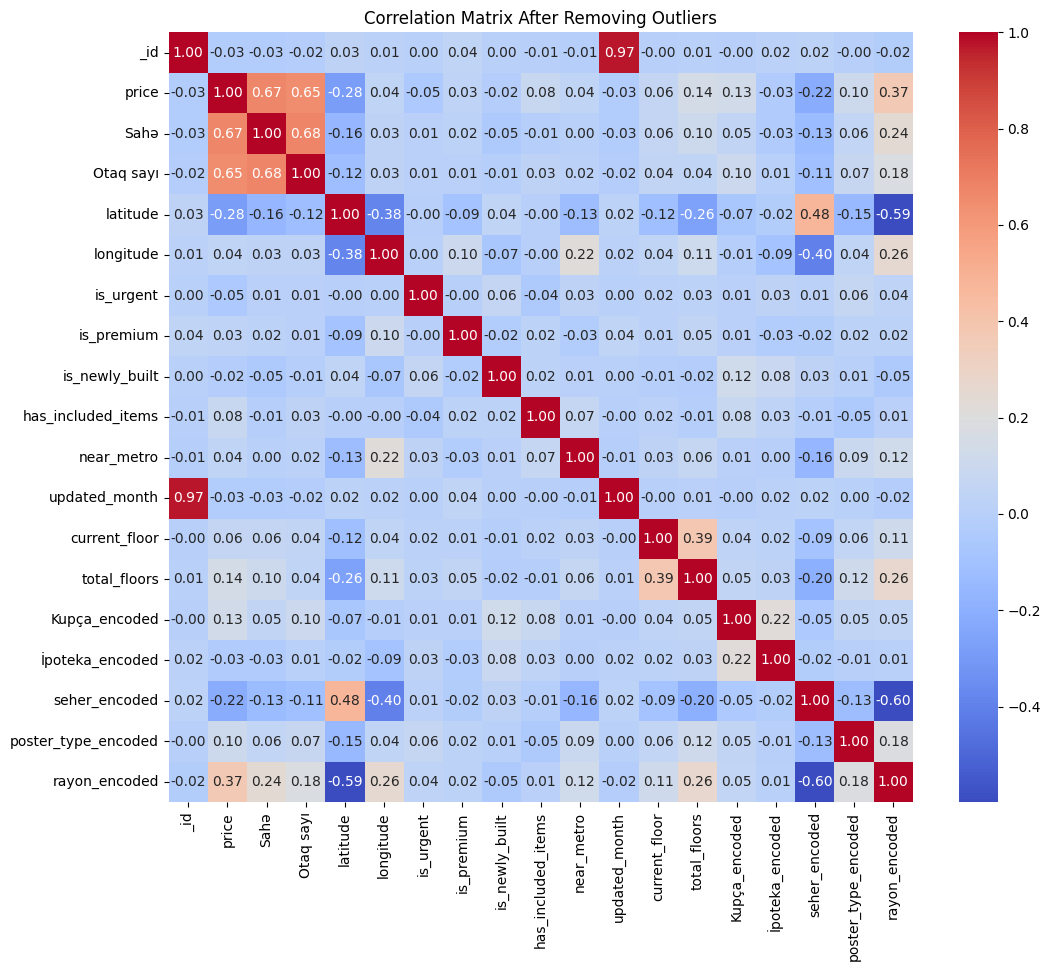

In [168]:
# Recompute correlation matrix
correlation_matrix_no_outliers = df_train.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_no_outliers, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix After Removing Outliers")
plt.show()

## Nearest Landmark Cluster ID

In [169]:
# Scale latitude and longitude
scaler = StandardScaler()
scaled_coords = scaler.fit_transform(landmarks[['Latitude', 'Longitude']])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjust eps and min_samples as needed
landmarks['cluster'] = dbscan.fit_predict(scaled_coords)

# Display cluster assignments
print("Cluster assignments for landmarks:")
print(landmarks[['Title', 'Latitude', 'Longitude', 'cluster']])

Cluster assignments for landmarks:
                   Title   Latitude  Longitude  cluster
0    Abşeron Milli Parkı  40.283000  50.350000       -1
1        Bakı arxipelaqı  40.283330  49.916670       -1
2               Daş Zirə  40.290730  49.977668       -1
3    Aşurbəyovun villası  40.293200  50.082000       -1
4     Bibiheybət məscidi  40.308610  49.820280       -1
..                   ...        ...        ...      ...
125    Azadlig Prospekti  40.426420  49.841787        1
126             Darnagul  40.425643  49.861897        1
127       Jafar Jabbarli  40.379868  49.849247        1
128    Shah Ismail Hatai  40.383315  49.871985        1
129           Avtovagzal  40.422247  49.795106        1

[130 rows x 4 columns]


In [170]:
landmarks['cluster'].value_counts()

cluster
 1    103
-1     11
 6      4
 2      3
 4      3
 0      2
 3      2
 5      2
Name: count, dtype: int64

In [171]:
# Compute centroids for each cluster
cluster_centroids = landmarks.groupby('cluster')[['Latitude', 'Longitude']].mean().reset_index()

In [173]:
# Optionally, add the cluster ID of the nearest cluster
def assign_nearest_cluster(df, centroids):
    nearest_clusters = []
    for index, row in df.iterrows():
        lat, lon = row['latitude'], row['longitude']
        dist = np.sqrt((centroids['Latitude'] - lat)**2 + (centroids['Longitude'] - lon)**2)
        nearest_clusters.append(centroids.loc[dist.idxmin(), 'cluster'])
    return nearest_clusters

In [174]:
df_train['nearest_cluster'] = assign_nearest_cluster(df_train, cluster_centroids)
df_test['nearest_cluster'] = assign_nearest_cluster(df_test, cluster_centroids)

In [175]:
# Save train data with nearest cluster
train_with_nearest_cluster = df_train[['nearest_cluster', '_id']]
train_with_nearest_cluster.to_csv("train_nearest_cluster.csv", index=False)
print("Train nearest cluster saved to 'train_nearest_cluster.csv'.")

# Save test data with nearest cluster
test_with_nearest_cluster = df_test[['nearest_cluster', '_id']]
test_with_nearest_cluster.to_csv("test_nearest_cluster.csv", index=False)
print("Test nearest cluster saved to 'test_nearest_cluster.csv'.")

Train nearest cluster saved to 'train_nearest_cluster.csv'.
Test nearest cluster saved to 'test_nearest_cluster.csv'.


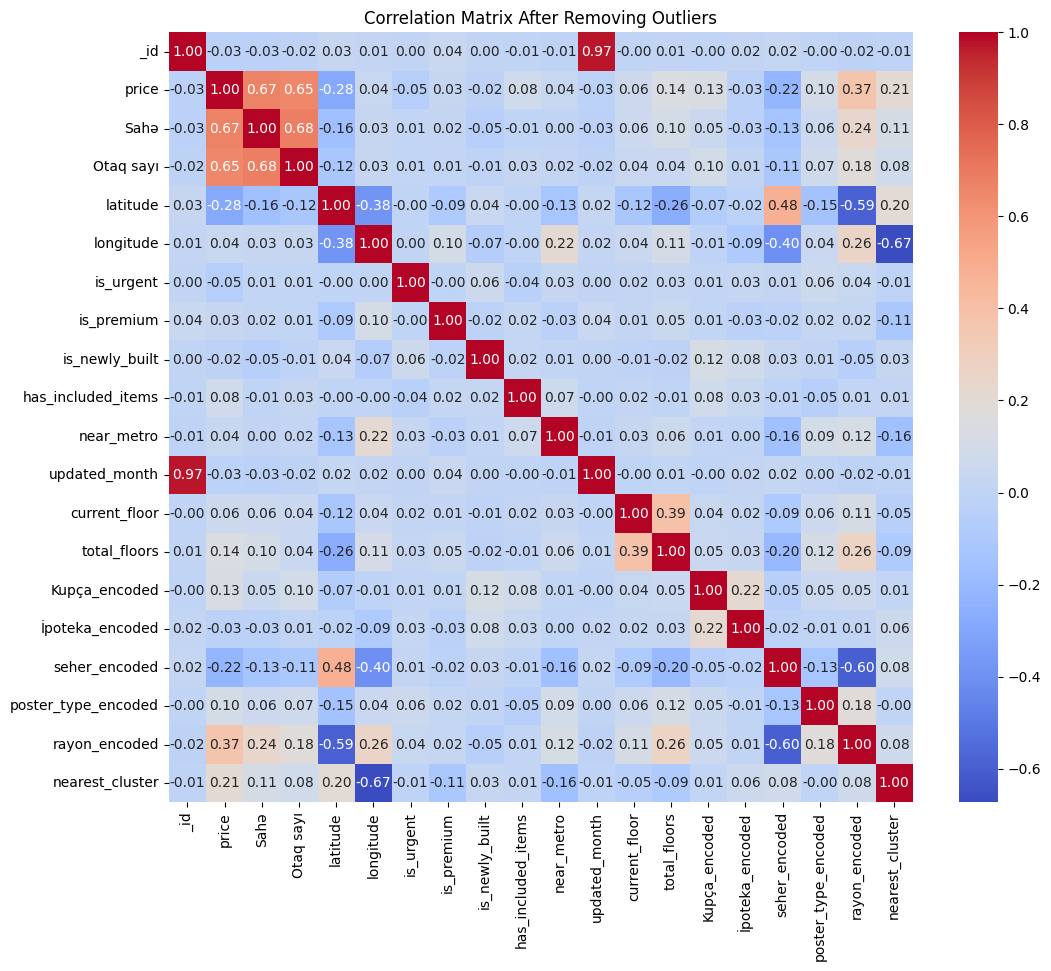

In [176]:
# Recompute correlation matrix
correlation_matrix_no_outliers = df_train.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_no_outliers, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix After Removing Outliers")
plt.show()

## Landmark and Price

In [177]:
# Function to prepare BallTree
def prepare_ball_tree(landmarks):
    coords = landmarks[['Latitude', 'Longitude']].to_numpy()
    return BallTree(coords, metric='haversine')

In [178]:
# Function to compute nearest landmarks and distances
def compute_landmark_features(df, ball_tree, landmark_coords, landmarks, k=3):
    coords = df[['latitude', 'longitude']].to_numpy()
    # Compute distances and indices of k nearest landmarks
    distances, indices = ball_tree.query(coords, k=k)
    nearest_landmarks = [
        [landmarks.iloc[idx]['Title'] for idx in row_indices] for row_indices in indices
    ]
    df['nearest_landmark'] = [landmarks.iloc[indices[i, 0]]['Title'] for i in range(len(indices))]
    df['distance_to_landmark'] = [distances[i, 0] for i in range(len(distances))]
    return df, nearest_landmarks

In [179]:
# Preprocess landmarks to compute mean prices
def preprocess_landmarks(df_train, landmarks):
    # Compute average prices for each landmark
    landmark_mean_prices = (
        df_train.groupby('nearest_landmark')['price']
        .mean()
        .reset_index()
        .rename(columns={'nearest_landmark': 'Title', 'price': 'mean_price'})
    )
    # Merge mean prices into landmarks
    landmarks = landmarks.merge(landmark_mean_prices, on='Title', how='left')
    return landmarks

In [180]:
# Assign clusters to landmarks based on mean prices
def assign_landmark_clusters(landmarks):
    le = LabelEncoder()
    landmarks['landmark_price_cluster'] = le.fit_transform(
        pd.qcut(landmarks['mean_price'], q=3, duplicates='drop')
    )
    return landmarks

In [181]:
# Map landmark clusters back to train/test data
def map_clusters_to_data(df, landmarks, nearest_landmarks):
    cluster_mapping = landmarks.set_index('Title')['landmark_price_cluster'].to_dict()
    df['landmark_price_cluster'] = [
        [cluster_mapping.get(landmark, -1) for landmark in landmark_list]
        for landmark_list in nearest_landmarks
    ]
    return df

In [182]:
# Prepare landmarks and compute nearest features
landmarks['cluster'] = -1  # Ensure cluster column exists
ball_tree = prepare_ball_tree(landmarks)

In [183]:
# Add nearest landmarks and distances to train
df_train, train_nearest_landmarks = compute_landmark_features(
    df_train, ball_tree, landmarks[['Latitude', 'Longitude']], landmarks, k=3
)

In [184]:
# Preprocess landmarks
landmarks = preprocess_landmarks(df_train, landmarks)

In [185]:
landmarks = assign_landmark_clusters(landmarks)

In [186]:
# Add clusters to train
df_train = map_clusters_to_data(df_train, landmarks, train_nearest_landmarks)

In [187]:
# Process test data
df_test, test_nearest_landmarks = compute_landmark_features(
    df_test, ball_tree, landmarks[['Latitude', 'Longitude']], landmarks, k=3
)
df_test = map_clusters_to_data(df_test, landmarks, test_nearest_landmarks)

In [188]:
# Ensure numeric-only features
df_train['landmark_price_cluster'] = df_train['landmark_price_cluster'].apply(lambda x: x[0])
df_test['landmark_price_cluster'] = df_test['landmark_price_cluster'].apply(lambda x: x[0])

In [189]:
# Drop unnecessary columns
df_train = df_train.drop(columns=['nearest_landmark', 'distance_to_landmark'], errors='ignore')
df_test = df_test.drop(columns=['nearest_landmark', 'distance_to_landmark'], errors='ignore')

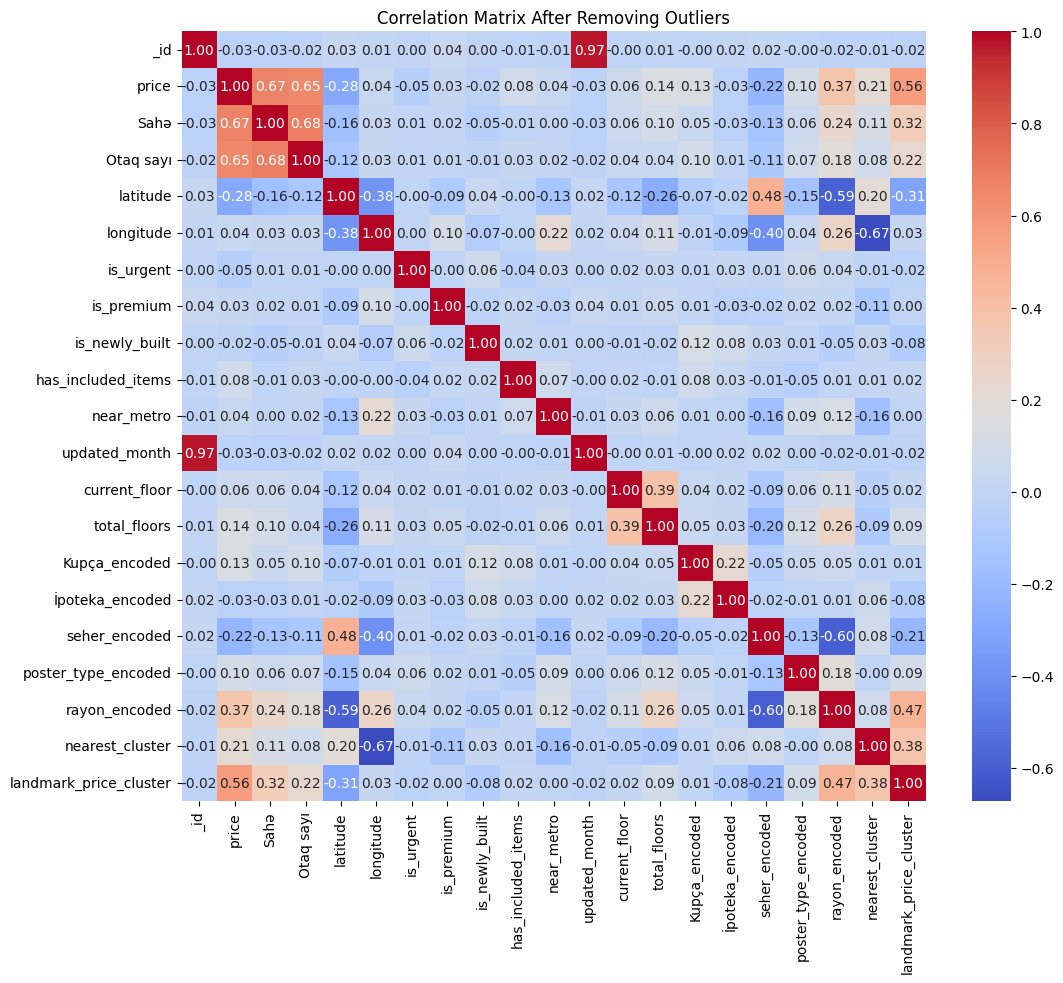

In [190]:
# Recompute correlation matrix
correlation_matrix_no_outliers = df_train.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_no_outliers, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix After Removing Outliers")
plt.show()

# Modeling

## XGBoost with Optuna

In [192]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 5, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 5, 10),
    }

    model = xgb.XGBRegressor(random_state=42, **param)
    
    # Perform cross-validation to avoid overfitting
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    rmse = np.sqrt(-scores.mean())
    return rmse

In [193]:
# Initialize Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
print("Starting Optuna optimization...")
study.optimize(objective, n_trials=50, timeout=3600)  # Adjust `n_trials` and `timeout` as needed

[I 2025-01-09 23:51:21,803] A new study created in memory with name: no-name-c5a580fd-b7ca-4bac-b021-ff561ce43f61


Starting Optuna optimization...


[I 2025-01-09 23:51:23,881] Trial 0 finished with value: 41952.66131140505 and parameters: {'n_estimators': 400, 'learning_rate': 0.06259481278534383, 'max_depth': 4, 'colsample_bytree': 0.6059426029653362, 'subsample': 0.7477604750455331, 'gamma': 1.1309017621761153, 'reg_alpha': 6.259135954921026, 'reg_lambda': 8.454069022238478}. Best is trial 0 with value: 41952.66131140505.
[I 2025-01-09 23:51:26,640] Trial 1 finished with value: 40730.01418421134 and parameters: {'n_estimators': 400, 'learning_rate': 0.051224094616007555, 'max_depth': 5, 'colsample_bytree': 0.6730512407435514, 'subsample': 0.7387333229270314, 'gamma': 1.0567549607283961, 'reg_alpha': 8.48466200022525, 'reg_lambda': 8.179525282206562}. Best is trial 1 with value: 40730.01418421134.
[I 2025-01-09 23:51:30,975] Trial 2 finished with value: 37407.3501539284 and parameters: {'n_estimators': 450, 'learning_rate': 0.09772260241165585, 'max_depth': 7, 'colsample_bytree': 0.6521545109886863, 'subsample': 0.624514136928680

[I 2025-01-09 23:52:55,200] Trial 22 finished with value: 36922.87773346859 and parameters: {'n_estimators': 450, 'learning_rate': 0.08745699891307228, 'max_depth': 8, 'colsample_bytree': 0.7305499131634597, 'subsample': 0.6443028607009944, 'gamma': 0.3196844486236769, 'reg_alpha': 8.188195061791705, 'reg_lambda': 8.801856822102888}. Best is trial 19 with value: 36757.79596993437.
[I 2025-01-09 23:52:59,693] Trial 23 finished with value: 37555.81008741237 and parameters: {'n_estimators': 400, 'learning_rate': 0.0884894231906543, 'max_depth': 7, 'colsample_bytree': 0.7438455913845081, 'subsample': 0.679649440226243, 'gamma': 2.916827442687047, 'reg_alpha': 7.126862242968832, 'reg_lambda': 9.482537930539209}. Best is trial 19 with value: 36757.79596993437.
[I 2025-01-09 23:53:07,236] Trial 24 finished with value: 36819.78645631812 and parameters: {'n_estimators': 450, 'learning_rate': 0.06983814495167312, 'max_depth': 8, 'colsample_bytree': 0.7772079945915824, 'subsample': 0.708317458297

[I 2025-01-09 23:54:47,279] Trial 44 finished with value: 36800.438974221855 and parameters: {'n_estimators': 500, 'learning_rate': 0.09919186966014697, 'max_depth': 8, 'colsample_bytree': 0.6972487777175664, 'subsample': 0.6196737252287192, 'gamma': 1.546337972443312, 'reg_alpha': 7.828745278355, 'reg_lambda': 7.265216359139869}. Best is trial 36 with value: 36639.313975757366.
[I 2025-01-09 23:54:51,824] Trial 45 finished with value: 38079.03507863278 and parameters: {'n_estimators': 500, 'learning_rate': 0.02982125258739427, 'max_depth': 8, 'colsample_bytree': 0.7509209875529883, 'subsample': 0.6674145634547046, 'gamma': 1.4295572270502652, 'reg_alpha': 7.357716175225079, 'reg_lambda': 8.837120135907572}. Best is trial 36 with value: 36639.313975757366.
[I 2025-01-09 23:54:56,260] Trial 46 finished with value: 36729.58610767974 and parameters: {'n_estimators': 500, 'learning_rate': 0.09133296198496996, 'max_depth': 8, 'colsample_bytree': 0.7282054568893862, 'subsample': 0.6852058643

In [199]:
# Best parameters and RMSE
print("Best Parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Train the best model
best_params = study.best_params
best_optuna_xgb_model = xgb.XGBRegressor(random_state=42, **best_params)

Best Parameters: {'n_estimators': 500, 'learning_rate': 0.09528960722098678, 'max_depth': 8, 'colsample_bytree': 0.706900297760177, 'subsample': 0.7246718271794946, 'gamma': 1.8291839600988937, 'reg_alpha': 9.449539257190166, 'reg_lambda': 6.6080476172356555}
Best RMSE: 36634.90938019727


In [200]:
best_optuna_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.706900297760177, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.8291839600988937,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09528960722098678,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Top 10 Important Features:
                   Feature  Importance
18  landmark_price_cluster    0.321485
0                     Sahə    0.254365
1                Otaq sayı    0.113896
12           Kupça_encoded    0.040420
16           rayon_encoded    0.033595
3                longitude    0.032260
2                 latitude    0.031563
17         nearest_cluster    0.031031
7       has_included_items    0.024594
11            total_floors    0.021080


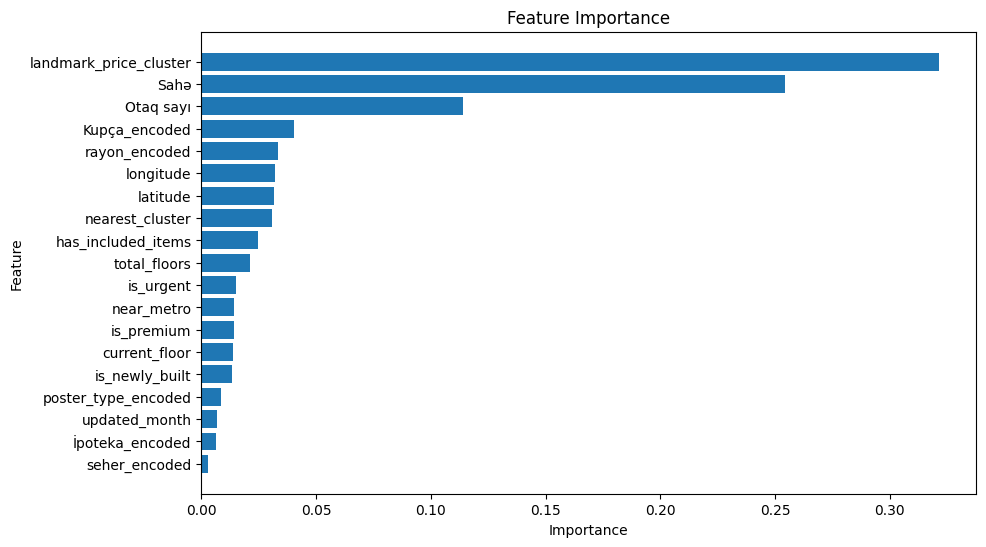

In [201]:
# Feature Importance
feature_importance = best_optuna_xgb_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Important Features:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [202]:
# Evaluate the model on the training set (optional)
y_pred_train = best_optuna_xgb_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print(f"Training RMSE: {train_rmse}")

# Making predictions on test data
y_pred_test = best_optuna_xgb_model.predict(X_test)

Training RMSE: 21020.93170433731


In [203]:
# Add the _id column back to the predictions for submission
sample_data['_id'] = df_test['_id']
sample_data['price'] = y_pred_test

# Save the submission file as CSV
sample_data.to_csv('sample_submission.csv', index=False)
print("The file 'sample_submission.csv' with '_id' and 'price' has been successfully saved.")

The file 'sample_submission.csv' with '_id' and 'price' has been successfully saved.
